In [1]:
# NOTE: Graphviz is not included in the requirements.txt file. 
# You must install it separately
import graphviz
import numpy as np

from sklearn import datasets

from groundupml.supervised.random_forest import RandomForest
from groundupml.utils.data_manipulation import split_data
from groundupml.utils.data_tools import confusion_matrix

%matplotlib inline

In [2]:
# Function to take a decision tree and return a graphviz object representation
def export_graphviz(tree, feature_names=None, class_names=None):
    dot = graphviz.Digraph()

    def add_node(node):
        # Get the node ID and label
        node_id = str(id(node))
        if node.value is not None:
            # Leaf Node
            node_label = class_names[node.value] if class_names is not None \
                else str(node.value)
            colorscheme_idx = node.value % 8  # 8 colors in the accent8 colorscheme
            dot.node(node_id, label=node_label, style='filled',
                     fillcolor='/accent8/' + str(colorscheme_idx))  # Color node by class
        else:
            # Non-leaf Node
            feature_name = feature_names[node.feature_index] if feature_names is not None \
                else 'f' + str(node.feature_index)
            node_label = f'{feature_name} <= {node.threshold:.1f}'
            dot.node(node_id, label=node_label, shape='box', fillcolor='lightblue2', 
                     style='filled')

            # Add edges for children
            left_child, right_child = node.children
            dot.edge(node_id, str(id(left_child)), color='#33a02c')  # True path
            dot.edge(node_id, str(id(right_child)), color='#e31a1c')  # False path

            # Build children
            add_node(left_child)
            add_node(right_child)
        
    add_node(tree.root)

    return dot

In [3]:
# Demonstrate forest can learn XOR function
np.random.seed(2)  # Set seed for reproducibility
X_train = np.array([[0, 0],
                    [1, 0],
                    [0, 1],
                    [1, 1],
                    [0, 0]])

y_train = np.array([0, 1, 1, 0, 0])

rf_xor = RandomForest(n_trees=3, max_depth=5, impurity_func='gini')
rf_xor.fit(X_train, y_train)

for tree in rf_xor.trees:
    print(tree)

X_test = X_train
predictions = rf_xor.predict(X_test)
print(predictions)

└────f0 <= 0
      └──T──0
      └──F──f1 <= 0
            └──T──1
            └──F──0

└────f0 <= 0
      ├──T──f1 <= 0
      │      └──T──0
      │      └──F──1
      └──F──f1 <= 0
            └──T──1
            └──F──0

└────f0 <= 0
      ├──T──f1 <= 0
      │      └──T──0
      │      └──F──1
      └──F──0

[0 1 1 0 0]


digraph {
	139844789096976 [label="bit0 <= 0.0" fillcolor=lightblue2 shape=box style=filled]
	139844789096976 -> 139844789095248 [color="#33a02c"]
	139844789096976 -> 139844789102400 [color="#e31a1c"]
	139844789095248 [label=0 fillcolor="/accent8/1" style=filled]
	139844789102400 [label="bit1 <= 0.0" fillcolor=lightblue2 shape=box style=filled]
	139844789102400 -> 139844789096736 [color="#33a02c"]
	139844789102400 -> 139844789101152 [color="#e31a1c"]
	139844789096736 [label=1 fillcolor="/accent8/2" style=filled]
	139844789101152 [label=0 fillcolor="/accent8/1" style=filled]
}



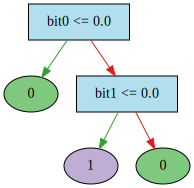

In [4]:

# Test with XOR function
graphviz_export = export_graphviz(rf_xor.trees[0], feature_names=['bit0', 'bit1'])
print(graphviz_export.source)
graphviz_export



In [5]:
# Test on Iris dataset

# Load data
np.random.seed(7)
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split into train and test sets
X_train, y_train, X_test, y_test = split_data(X, y, proportion=0.8)

# Train model
rf_iris = RandomForest(n_trees=3, max_depth=2, impurity_func='gini', max_features=3)
rf_iris.fit(X_train, y_train)

# Make predictions
predictions = rf_iris.predict(X_test)
print('Predictions:', predictions)
print('Actual:', y_test)
print(confusion_matrix(y_test, predictions))

Predictions: [0 1 1 2 2 1 2 2 1 1 1 0 0 1 1 0 2 2 1 2 0 2 1 2 0 2 1 2 1 0]
Actual: [0 1 1 2 2 1 2 0 1 1 0 0 0 1 1 0 2 2 1 2 0 2 1 1 0 2 1 2 1 0]
[[ 7.  1.  1.]
 [ 0. 11.  1.]
 [ 0.  0.  9.]]


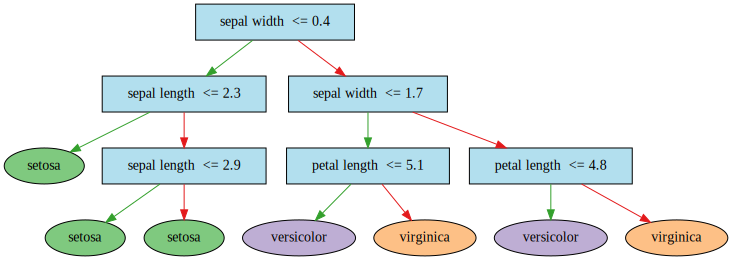

In [6]:
# Visualize forest using graphviz

# Clean up feature names for cleaner graphviz output
feat_names = [name.replace('(cm)', '') for name in iris.feature_names]
class_names = iris.target_names

graphviz_trees = []
for tree in rf_iris.trees:
    graphviz_trees.append(export_graphviz(tree, 
                                          feature_names=feat_names,
                                          class_names=class_names))

graphviz_trees[0]
